In [2]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [3]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/noisemaker_light/noisemaker_light.csv'
SAMPLES_FOLDER = '../data/noisemaker_light/noisemaker_light_samples/'
FOLDER_PREFIX = 'noisemaker_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

N_EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

RESULTS-noisemaker_light-2018-01-09_17:01.csv


# Prepares datasets

In [5]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   lfo1_rate  filter_cutoff  lfo1_amount osc2_wave  filter_resonance    file
0   0.629921       1.811024     2.755906      Sine          1.653543  s0.wav
1   8.818898       1.496063     1.653543      Sine          3.464567  s1.wav
2   5.590551       8.346457     5.118110     Pulse          4.251969  s2.wav
3   6.535433       9.291339     5.748031       Saw          5.039370  s3.wav
4   9.212598       0.078740     4.803150     Pulse          6.614173  s4.wav
800 200

Training data: (800, 6)
Test data: (200, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
800    s800.wav
801    s801.wav
802    s802.wav
803    s803.wav
804    s804.wav
Name: file, dtype: object


In [6]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
(200, 19845)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
(800, 19845)


# Independent models

## Prepares the features

In [7]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(200, 20, 39)
(800, 20, 39)


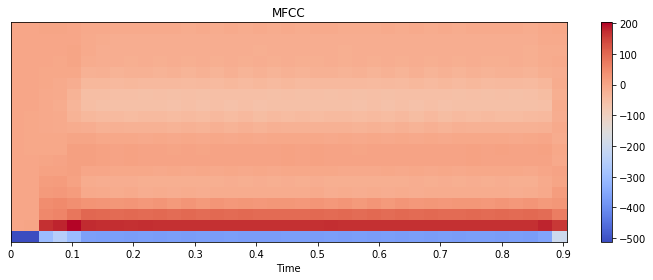

In [8]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[140,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [9]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(200, 780)
(800, 780)


## Predictions

In [10]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [ ]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

In [21]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.5s finished


[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.3s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.7s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished


0.885
0.875
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'osc2_wave', 'class', 0.88500000000000001, 0.875)
predicting feature filter_resonance
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.2s finished


2.21604796571
1.9707003929
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'filter_resonance', 'reg', 2.2160479657054601, 1.9707003928993896)


In [22]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.47532804526
2.6774015748
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'lfo1_rate', 'reg', 2.4753280452584878, 2.6774015748033846)
predicting feature filter_cutoff
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] ...............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [23]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling + mid-level features

In [24]:
def target_info(df_y):
    infos = {}
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

lfo1_rate
filter_cutoff
lfo1_amount
osc2_wave
filter_resonance
{'lfo1_rate': {'sd': 2.8756837733162297, 'type': dtype('float64'), 'mean': 5.064960629921563}, 'filter_cutoff': {'sd': 2.89234557524474, 'type': dtype('float64'), 'mean': 5.0103346456694338}, 'osc2_wave': {'char2int': {'Sine': 3, 'Noise': 0, 'Saw': 2, 'Triangle': 4, 'Pulse': 1}, 'int2char': {0: 'Noise', 1: 'Pulse', 2: 'Saw', 3: 'Sine', 4: 'Triangle'}, 'type': dtype('O')}, 'lfo1_amount': {'sd': 2.932316237542842, 'type': dtype('float64'), 'mean': 4.9543307086615656}, 'filter_resonance': {'sd': 2.9479893137687894, 'type': dtype('float64'), 'mean': 5.0626968503939489}}


In [25]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(200, 32, 39)
(800, 32, 39)


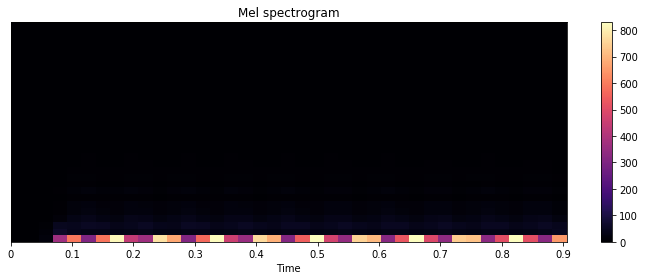

In [26]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [27]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(800, 39, 32) (200, 39, 32)


In [28]:
def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mel, axis=(0))
    X_sd = np.std(X_train_mel, axis=(0))
    
    X_train = (X_train_mel - X_mean) / X_sd
    X_test  = (X_test_mel - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION)
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

In [29]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name, 
                              kernel_regularizer=regularizers.l2(regul))(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, kernel_regularizer=regularizers.l2(regul),
                              activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [16,32,64]:
        for REGUL in [0,0.01,0.1,1]:
            model = MLP(N_UNITS, N_LAYERS, REGUL)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_33 (InputLayer)            (None, 39, 32)        0                                            
____________________________________________________________________________________________________
flatten_33 (Flatten)             (None, 1248)          0                                            
____________________________________________________________________________________________________
dense_49 (Dense)                 (None, 8)             9992                                         
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             9                                            
___________________________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 1s - loss: 6.0233 - lfo1_rate_loss: 1.0892 - filter_cutoff_loss: 1.1125 - osc2_wave_loss: 1.5751 - lfo1_amount_loss: 1.0962 - filter_resonance_loss: 1.0188 - val_loss: 4.9856 - val_lfo1_rate_loss: 0.9345 - val_filter_cutoff_loss: 0.8306 - val_osc2_wave_loss: 1.3946 - val_lfo1_amount_loss: 0.8635 - val_filter_resonance_loss: 0.8326
Epoch 2/10
720/720 [==============================] - 0s - loss: 5.2681 - lfo1_rate_loss: 0.9354 - filter_cutoff_loss: 0.9130 - osc2_wave_loss: 1.3893 - lfo1_amount_loss: 1.0006 - filter_resonance_loss: 0.9012 - val_loss: 4.7451 - val_lfo1_rate_loss: 0.8857 - val_filter_cutoff_loss: 0.6986 - val_osc2_wave_loss: 1.3275 - val_lfo1_amount_loss: 0.8994 - val_filter_resonance_loss: 0.8063
Epoch 3/10
720/720 [==============================] - 0s - loss: 4.9213 - lfo1_rate_loss: 0.9047 - filter_cutoff_loss: 0.8195 - osc2_wave_loss: 1.2760 - lfo1_amount_loss: 0.9403 - f

720/720 [==============================] - 0s - loss: 5.9669 - lfo1_rate_loss: 0.9714 - filter_cutoff_loss: 0.7084 - osc2_wave_loss: 1.2997 - lfo1_amount_loss: 0.8814 - filter_resonance_loss: 0.8916 - val_loss: 5.8296 - val_lfo1_rate_loss: 0.9558 - val_filter_cutoff_loss: 0.6542 - val_osc2_wave_loss: 1.2894 - val_lfo1_amount_loss: 0.8369 - val_filter_resonance_loss: 0.9088
Epoch 5/10
720/720 [==============================] - 0s - loss: 5.7467 - lfo1_rate_loss: 0.9325 - filter_cutoff_loss: 0.6806 - osc2_wave_loss: 1.3011 - lfo1_amount_loss: 0.8346 - filter_resonance_loss: 0.8383 - val_loss: 5.8447 - val_lfo1_rate_loss: 0.9827 - val_filter_cutoff_loss: 0.7274 - val_osc2_wave_loss: 1.2336 - val_lfo1_amount_loss: 0.8431 - val_filter_resonance_loss: 0.9268
Epoch 6/10
720/720 [==============================] - 0s - loss: 5.6091 - lfo1_rate_loss: 0.9431 - filter_cutoff_loss: 0.6714 - osc2_wave_loss: 1.2265 - lfo1_amount_loss: 0.8307 - filter_resonance_loss: 0.8295 - val_loss: 5.6438 - val_lf

720/720 [==============================] - 0s - loss: 12.6411 - lfo1_rate_loss: 0.8201 - filter_cutoff_loss: 0.6890 - osc2_wave_loss: 1.3230 - lfo1_amount_loss: 0.8582 - filter_resonance_loss: 0.7953 - val_loss: 12.5587 - val_lfo1_rate_loss: 0.9441 - val_filter_cutoff_loss: 0.7243 - val_osc2_wave_loss: 1.3217 - val_lfo1_amount_loss: 0.9079 - val_filter_resonance_loss: 0.8147
Epoch 8/10
720/720 [==============================] - 0s - loss: 11.9804 - lfo1_rate_loss: 0.8066 - filter_cutoff_loss: 0.6568 - osc2_wave_loss: 1.3022 - lfo1_amount_loss: 0.8426 - filter_resonance_loss: 0.7810 - val_loss: 11.9353 - val_lfo1_rate_loss: 0.9317 - val_filter_cutoff_loss: 0.7224 - val_osc2_wave_loss: 1.2769 - val_lfo1_amount_loss: 0.9033 - val_filter_resonance_loss: 0.7988
Epoch 9/10
720/720 [==============================] - 0s - loss: 11.3762 - lfo1_rate_loss: 0.8068 - filter_cutoff_loss: 0.6213 - osc2_wave_loss: 1.2760 - lfo1_amount_loss: 0.8302 - filter_resonance_loss: 0.7779 - val_loss: 11.4505 - 

 43/200 [=====>........................] - ETA: 4slfo1_rate
(200, 1)
('MLP', 'joint', 16, 1, 0, 'lfo1_rate', 'reg', -3.4917697813775805, 3.1799684910046393)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 1, 0, 'filter_cutoff', 'reg', -3.4917697813775805, 2.3377715333711353)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 1, 0, 'osc2_wave', 'class', -3.4917697813775805, 0.69499999999999995)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 1, 0, 'lfo1_amount', 'reg', -3.4917697813775805, 3.2173146802232471)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 1, 0, 'filter_resonance', 'reg', -3.4917697813775805, 2.3471058031236391)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_38 (InputLayer)            (None, 39, 32)        0                                            
___________________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 1s - loss: 7.8234 - lfo1_rate_loss: 1.0750 - filter_cutoff_loss: 1.0835 - osc2_wave_loss: 1.6983 - lfo1_amount_loss: 1.3617 - filter_resonance_loss: 1.0888 - val_loss: 6.5066 - val_lfo1_rate_loss: 0.8823 - val_filter_cutoff_loss: 0.7862 - val_osc2_wave_loss: 1.4714 - val_lfo1_amount_loss: 1.0455 - val_filter_resonance_loss: 0.8508
Epoch 2/10
720/720 [==============================] - 0s - loss: 6.6559 - lfo1_rate_loss: 0.9539 - filter_cutoff_loss: 0.8876 - osc2_wave_loss: 1.3439 - lfo1_amount_loss: 1.0634 - filter_resonance_loss: 0.9734 - val_loss: 6.3474 - val_lfo1_rate_loss: 0.8806 - val_filter_cutoff_loss: 0.8220 - val_osc2_wave_loss: 1.3683 - val_lfo1_amount_loss: 1.0360 - val_filter_resonance_loss: 0.8476
Epoch 3/10
720/720 [==============================] - 0s - loss: 6.0708 - lfo1_rate_loss: 0.9073 - filter_cutoff_loss: 0.7523 - osc2_wave_loss: 1.2018 - lfo1_amount_loss: 0.9440 - f

720/720 [==============================] - 0s - loss: 14.0749 - lfo1_rate_loss: 0.8255 - filter_cutoff_loss: 0.7027 - osc2_wave_loss: 1.0026 - lfo1_amount_loss: 0.8837 - filter_resonance_loss: 0.7718 - val_loss: 13.8665 - val_lfo1_rate_loss: 1.0154 - val_filter_cutoff_loss: 0.6387 - val_osc2_wave_loss: 1.0853 - val_lfo1_amount_loss: 0.9307 - val_filter_resonance_loss: 0.8136
Epoch 5/10
720/720 [==============================] - 0s - loss: 12.9891 - lfo1_rate_loss: 0.7978 - filter_cutoff_loss: 0.6597 - osc2_wave_loss: 0.9310 - lfo1_amount_loss: 0.8546 - filter_resonance_loss: 0.7753 - val_loss: 12.9215 - val_lfo1_rate_loss: 0.9940 - val_filter_cutoff_loss: 0.6354 - val_osc2_wave_loss: 1.0499 - val_lfo1_amount_loss: 0.9169 - val_filter_resonance_loss: 0.8162
Epoch 6/10
720/720 [==============================] - 0s - loss: 12.0229 - lfo1_rate_loss: 0.7858 - filter_cutoff_loss: 0.6268 - osc2_wave_loss: 0.9058 - lfo1_amount_loss: 0.8376 - filter_resonance_loss: 0.7322 - val_loss: 12.0506 - 

720/720 [==============================] - 0s - loss: 3.3440 - lfo1_rate_loss: 0.7560 - filter_cutoff_loss: 0.6092 - osc2_wave_loss: 0.5131 - lfo1_amount_loss: 0.7792 - filter_resonance_loss: 0.6864 - val_loss: 4.0052 - val_lfo1_rate_loss: 0.8879 - val_filter_cutoff_loss: 0.7015 - val_osc2_wave_loss: 0.6453 - val_lfo1_amount_loss: 0.9273 - val_filter_resonance_loss: 0.8433
Epoch 8/10
720/720 [==============================] - 0s - loss: 3.2269 - lfo1_rate_loss: 0.7481 - filter_cutoff_loss: 0.5831 - osc2_wave_loss: 0.4724 - lfo1_amount_loss: 0.7688 - filter_resonance_loss: 0.6544 - val_loss: 3.9558 - val_lfo1_rate_loss: 0.8605 - val_filter_cutoff_loss: 0.6783 - val_osc2_wave_loss: 0.5806 - val_lfo1_amount_loss: 0.9777 - val_filter_resonance_loss: 0.8587
Epoch 9/10
720/720 [==============================] - 0s - loss: 3.1298 - lfo1_rate_loss: 0.7521 - filter_cutoff_loss: 0.5495 - osc2_wave_loss: 0.4370 - lfo1_amount_loss: 0.7391 - filter_resonance_loss: 0.6521 - val_loss: 3.9973 - val_lf

 43/200 [=====>........................] - ETA: 5slfo1_rate
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'lfo1_rate', 'reg', -3.307235724065039, 3.242306425778076)
filter_cutoff
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'filter_cutoff', 'reg', -3.307235724065039, 2.0364838789581405)
osc2_wave
(200, 5)
('MLP', 'joint', 32, 1, 0.01, 'osc2_wave', 'class', -3.307235724065039, 0.84499999999999997)
lfo1_amount
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'lfo1_amount', 'reg', -3.307235724065039, 3.3545240793455067)
filter_resonance
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'filter_resonance', 'reg', -3.307235724065039, 2.5721359785615867)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_43 (InputLayer)            (None, 39, 32)        0                                            
__________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 2s - loss: 20.4993 - lfo1_rate_loss: 1.2346 - filter_cutoff_loss: 1.0534 - osc2_wave_loss: 1.5519 - lfo1_amount_loss: 1.0700 - filter_resonance_loss: 1.0472 - val_loss: 18.1014 - val_lfo1_rate_loss: 0.9331 - val_filter_cutoff_loss: 0.7043 - val_osc2_wave_loss: 1.1875 - val_lfo1_amount_loss: 0.8780 - val_filter_resonance_loss: 0.7993
Epoch 2/10
720/720 [==============================] - 0s - loss: 17.5360 - lfo1_rate_loss: 0.9589 - filter_cutoff_loss: 0.7698 - osc2_wave_loss: 1.1176 - lfo1_amount_loss: 0.9487 - filter_resonance_loss: 0.9100 - val_loss: 16.2803 - val_lfo1_rate_loss: 0.9364 - val_filter_cutoff_loss: 0.6856 - val_osc2_wave_loss: 1.0261 - val_lfo1_amount_loss: 0.8745 - val_filter_resonance_loss: 0.7829
Epoch 3/10
720/720 [==============================] - 0s - loss: 15.4380 - lfo1_rate_loss: 0.8779 - filter_cutoff_loss: 0.6834 - osc2_wave_loss: 0.9340 - lfo1_amount_loss: 0.862

720/720 [==============================] - 0s - loss: 3.6533 - lfo1_rate_loss: 0.8954 - filter_cutoff_loss: 0.6619 - osc2_wave_loss: 0.5289 - lfo1_amount_loss: 0.8225 - filter_resonance_loss: 0.7445 - val_loss: 3.8252 - val_lfo1_rate_loss: 1.0041 - val_filter_cutoff_loss: 0.6094 - val_osc2_wave_loss: 0.5739 - val_lfo1_amount_loss: 0.8532 - val_filter_resonance_loss: 0.7847
Epoch 5/10
720/720 [==============================] - 0s - loss: 3.4090 - lfo1_rate_loss: 0.8310 - filter_cutoff_loss: 0.6136 - osc2_wave_loss: 0.4634 - lfo1_amount_loss: 0.7852 - filter_resonance_loss: 0.7159 - val_loss: 3.7030 - val_lfo1_rate_loss: 0.9788 - val_filter_cutoff_loss: 0.6206 - val_osc2_wave_loss: 0.5172 - val_lfo1_amount_loss: 0.8158 - val_filter_resonance_loss: 0.7707
Epoch 6/10
720/720 [==============================] - 0s - loss: 3.3346 - lfo1_rate_loss: 0.8574 - filter_cutoff_loss: 0.5855 - osc2_wave_loss: 0.4127 - lfo1_amount_loss: 0.7650 - filter_resonance_loss: 0.7140 - val_loss: 3.7118 - val_lf

720/720 [==============================] - 0s - loss: 3.3924 - lfo1_rate_loss: 0.7959 - filter_cutoff_loss: 0.5838 - osc2_wave_loss: 0.4189 - lfo1_amount_loss: 0.7887 - filter_resonance_loss: 0.6503 - val_loss: 3.6782 - val_lfo1_rate_loss: 0.9839 - val_filter_cutoff_loss: 0.5839 - val_osc2_wave_loss: 0.3910 - val_lfo1_amount_loss: 0.8468 - val_filter_resonance_loss: 0.7181
Epoch 8/10
720/720 [==============================] - 0s - loss: 3.2940 - lfo1_rate_loss: 0.7808 - filter_cutoff_loss: 0.5653 - osc2_wave_loss: 0.3898 - lfo1_amount_loss: 0.7427 - filter_resonance_loss: 0.6613 - val_loss: 3.8038 - val_lfo1_rate_loss: 0.9809 - val_filter_cutoff_loss: 0.6157 - val_osc2_wave_loss: 0.3970 - val_lfo1_amount_loss: 0.8991 - val_filter_resonance_loss: 0.7572
Epoch 9/10
720/720 [==============================] - 0s - loss: 3.2177 - lfo1_rate_loss: 0.7767 - filter_cutoff_loss: 0.5434 - osc2_wave_loss: 0.3642 - lfo1_amount_loss: 0.7459 - filter_resonance_loss: 0.6340 - val_loss: 3.6873 - val_lf

 43/200 [=====>........................] - ETA: 5slfo1_rate
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'lfo1_rate', 'reg', -4.0746916254361469, 2.8209437551744792)
filter_cutoff
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'filter_cutoff', 'reg', -4.0746916254361469, 1.9117247247230083)
osc2_wave
(200, 5)
('MLP', 'joint', 64, 1, 0.1, 'osc2_wave', 'class', -4.0746916254361469, 0.82999999999999996)
lfo1_amount
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'lfo1_amount', 'reg', -4.0746916254361469, 3.2429240755113757)
filter_resonance
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'filter_resonance', 'reg', -4.0746916254361469, 2.4524683656935107)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_48 (InputLayer)            (None, 39, 32)        0                                            
_________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 2s - loss: 5.7578 - lfo1_rate_loss: 1.0765 - filter_cutoff_loss: 0.8983 - osc2_wave_loss: 1.8705 - lfo1_amount_loss: 0.9583 - filter_resonance_loss: 0.9541 - val_loss: 5.1268 - val_lfo1_rate_loss: 0.9987 - val_filter_cutoff_loss: 0.7317 - val_osc2_wave_loss: 1.6603 - val_lfo1_amount_loss: 0.8842 - val_filter_resonance_loss: 0.8518
Epoch 2/10
720/720 [==============================] - 0s - loss: 5.1559 - lfo1_rate_loss: 0.9214 - filter_cutoff_loss: 0.8080 - osc2_wave_loss: 1.6438 - lfo1_amount_loss: 0.8825 - filter_resonance_loss: 0.9002 - val_loss: 4.9189 - val_lfo1_rate_loss: 0.8825 - val_filter_cutoff_loss: 0.6844 - val_osc2_wave_loss: 1.6314 - val_lfo1_amount_loss: 0.8583 - val_filter_resonance_loss: 0.8624
Epoch 3/10
720/720 [==============================] - 0s - loss: 4.9095 - lfo1_rate_loss: 0.8662 - filter_cutoff_loss: 0.7548 - osc2_wave_loss: 1.5370 - lfo1_amount_loss: 0.8720 - f

720/720 [==============================] - 0s - loss: 5.0108 - lfo1_rate_loss: 0.8513 - filter_cutoff_loss: 0.7070 - osc2_wave_loss: 1.4984 - lfo1_amount_loss: 0.8871 - filter_resonance_loss: 0.9394 - val_loss: 4.9460 - val_lfo1_rate_loss: 0.9113 - val_filter_cutoff_loss: 0.6222 - val_osc2_wave_loss: 1.5174 - val_lfo1_amount_loss: 0.8899 - val_filter_resonance_loss: 0.8793
Epoch 4/10
720/720 [==============================] - 0s - loss: 4.9162 - lfo1_rate_loss: 0.8469 - filter_cutoff_loss: 0.6917 - osc2_wave_loss: 1.4935 - lfo1_amount_loss: 0.8729 - filter_resonance_loss: 0.8862 - val_loss: 4.8431 - val_lfo1_rate_loss: 0.8937 - val_filter_cutoff_loss: 0.6076 - val_osc2_wave_loss: 1.5000 - val_lfo1_amount_loss: 0.8728 - val_filter_resonance_loss: 0.8454
Epoch 5/10
720/720 [==============================] - ETA: 0s - loss: 4.8221 - lfo1_rate_loss: 0.8481 - filter_cutoff_loss: 0.6579 - osc2_wave_loss: 1.4652 - lfo1_amount_loss: 0.8692 - filter_resonance_loss: 0.858 - 0s - loss: 4.8152 - l

720/720 [==============================] - 0s - loss: 5.8436 - lfo1_rate_loss: 0.8010 - filter_cutoff_loss: 0.7926 - osc2_wave_loss: 1.5108 - lfo1_amount_loss: 0.8356 - filter_resonance_loss: 0.8602 - val_loss: 5.7988 - val_lfo1_rate_loss: 0.9215 - val_filter_cutoff_loss: 0.6853 - val_osc2_wave_loss: 1.5515 - val_lfo1_amount_loss: 0.8384 - val_filter_resonance_loss: 0.7928
Epoch 6/10
720/720 [==============================] - 0s - loss: 5.7316 - lfo1_rate_loss: 0.8061 - filter_cutoff_loss: 0.7848 - osc2_wave_loss: 1.4780 - lfo1_amount_loss: 0.8352 - filter_resonance_loss: 0.8461 - val_loss: 5.6901 - val_lfo1_rate_loss: 0.9054 - val_filter_cutoff_loss: 0.6726 - val_osc2_wave_loss: 1.5250 - val_lfo1_amount_loss: 0.8426 - val_filter_resonance_loss: 0.7949
Epoch 7/10
720/720 [==============================] - 0s - loss: 5.6066 - lfo1_rate_loss: 0.7967 - filter_cutoff_loss: 0.7670 - osc2_wave_loss: 1.4495 - lfo1_amount_loss: 0.8294 - filter_resonance_loss: 0.8398 - val_loss: 5.5828 - val_lf

720/720 [==============================] - 0s - loss: 12.7188 - lfo1_rate_loss: 0.8196 - filter_cutoff_loss: 0.8231 - osc2_wave_loss: 1.3409 - lfo1_amount_loss: 0.8284 - filter_resonance_loss: 0.7794 - val_loss: 12.6331 - val_lfo1_rate_loss: 0.8917 - val_filter_cutoff_loss: 0.8206 - val_osc2_wave_loss: 1.4445 - val_lfo1_amount_loss: 0.8724 - val_filter_resonance_loss: 0.7836
Epoch 8/10
720/720 [==============================] - 0s - loss: 12.1298 - lfo1_rate_loss: 0.8270 - filter_cutoff_loss: 0.8157 - osc2_wave_loss: 1.3114 - lfo1_amount_loss: 0.8240 - filter_resonance_loss: 0.7846 - val_loss: 12.0749 - val_lfo1_rate_loss: 0.9063 - val_filter_cutoff_loss: 0.8139 - val_osc2_wave_loss: 1.4283 - val_lfo1_amount_loss: 0.8610 - val_filter_resonance_loss: 0.7850
Epoch 9/10
720/720 [==============================] - 0s - loss: 11.5734 - lfo1_rate_loss: 0.8153 - filter_cutoff_loss: 0.8183 - osc2_wave_loss: 1.3012 - lfo1_amount_loss: 0.8196 - filter_resonance_loss: 0.7758 - val_loss: 11.5647 - 

 43/200 [=====>........................] - ETA: 6slfo1_rate
(200, 1)
('MLP', 'joint', 16, 2, 0, 'lfo1_rate', 'reg', -3.3443471024433773, 2.7749184164479641)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 2, 0, 'filter_cutoff', 'reg', -3.3443471024433773, 1.8539789952350816)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 2, 0, 'osc2_wave', 'class', -3.3443471024433773, 0.755)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 2, 0, 'lfo1_amount', 'reg', -3.3443471024433773, 2.9187663804452177)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 2, 0, 'filter_resonance', 'reg', -3.3443471024433773, 2.2592369974692295)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_54 (InputLayer)            (None, 39, 32)        0                                            
_________________________________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 2s - loss: 7.6904 - lfo1_rate_loss: 0.9730 - filter_cutoff_loss: 1.1479 - osc2_wave_loss: 1.6931 - lfo1_amount_loss: 1.0768 - filter_resonance_loss: 1.3147 - val_loss: 6.6186 - val_lfo1_rate_loss: 0.8798 - val_filter_cutoff_loss: 0.7423 - val_osc2_wave_loss: 1.5363 - val_lfo1_amount_loss: 0.9906 - val_filter_resonance_loss: 1.0344
Epoch 2/10
720/720 [==============================] - 0s - loss: 6.6119 - lfo1_rate_loss: 0.8544 - filter_cutoff_loss: 0.8068 - osc2_wave_loss: 1.5279 - lfo1_amount_loss: 0.9160 - filter_resonance_loss: 1.1138 - val_loss: 6.3164 - val_lfo1_rate_loss: 0.8774 - val_filter_cutoff_loss: 0.6541 - val_osc2_wave_loss: 1.5157 - val_lfo1_amount_loss: 0.9290 - val_filter_resonance_loss: 0.9953
Epoch 3/10
720/720 [==============================] - 0s - loss: 6.2214 - lfo1_rate_loss: 0.8193 - filter_cutoff_loss: 0.7398 - osc2_wave_loss: 1.4668 - lfo1_amount_loss: 0.8727 - f

720/720 [==============================] - 0s - loss: 16.4237 - lfo1_rate_loss: 0.8351 - filter_cutoff_loss: 0.7056 - osc2_wave_loss: 1.1259 - lfo1_amount_loss: 0.8765 - filter_resonance_loss: 0.7755 - val_loss: 15.9337 - val_lfo1_rate_loss: 0.9143 - val_filter_cutoff_loss: 0.6748 - val_osc2_wave_loss: 1.1306 - val_lfo1_amount_loss: 0.8874 - val_filter_resonance_loss: 0.7976
Epoch 4/10
720/720 [==============================] - 0s - loss: 15.2034 - lfo1_rate_loss: 0.8345 - filter_cutoff_loss: 0.6704 - osc2_wave_loss: 1.0493 - lfo1_amount_loss: 0.8590 - filter_resonance_loss: 0.7287 - val_loss: 14.7908 - val_lfo1_rate_loss: 0.8707 - val_filter_cutoff_loss: 0.6432 - val_osc2_wave_loss: 1.1124 - val_lfo1_amount_loss: 0.8427 - val_filter_resonance_loss: 0.7857
Epoch 5/10
720/720 [==============================] - 0s - loss: 14.1028 - lfo1_rate_loss: 0.8268 - filter_cutoff_loss: 0.6277 - osc2_wave_loss: 0.9948 - lfo1_amount_loss: 0.8500 - filter_resonance_loss: 0.6963 - val_loss: 13.8019 - 

KeyboardInterrupt: 

In [ ]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,128]:
        for REGUL in [0,0.01,0.1,1]:
            model = modLSTM(N_UNITS, N_LAYERS, REGUL)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model)

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        for REGUL in [0,0.01,0.1,1]:
            model = modConvo(N_FILTERS, N_LAYERS, REGUL)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model)

# Visualizing the results

  algo  type param1 param2 regularization train_score
1  MLP joint     64      2              0   -2.778507
           algo metric    score
1 Decision Tree  class 0.857500
2 Decision Tree    reg 2.170839
3           kNN  class 0.835000
4           kNN    reg 1.906202
5           MLP  class 0.875000
6           MLP    reg 2.605075
7         Naive  class 0.230000
8         Naive    reg 2.615555


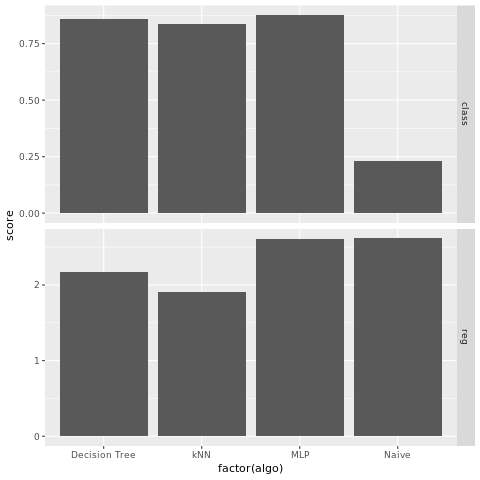

In [33]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
